# Задание 6. Применение микролокального анализа в томографии : лямбда-томография. Внутренняя задача томографии.

In [678]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.fft import ifft2, fft2, fft, fftshift, ifft, ifftshift, fftn, ifftn
from scipy.special import erf
from scipy import ndimage
from sem2utilities import adjradon2d
from pynufft import NUFFT

## Лямбда-томография

В данном задании мы познакомимся с одним из примеров применения микролокального анализа в томографии - лямбда-томографии (почему "лямбда" станет понятно чуть ниже). Напомним, что формула Радона в 2D случае выглядит следующим образом:

\begin{align}
    f(x) = \dfrac{1}{4\pi}R^* H[\dfrac{d}{ds}Rf], \, x\in R^2, 
\end{align}

где $R^*$ - двойственное преобразование Радона, $H$ - преобразование Гильберта. 

Как мы уже говорили, формула выше применима, если в задаче у нас есть доступ к полным данным $Rf(s,\theta)$, $s\in R$, $\theta\in S^1$. В противном же случае одно из принципиальных неудобств этой формулы - **её нелокальность** (ввиду преобразования Гильберта). Логично, что если мы хотим получить значение $f(x)$ в конкретой точке $x$, то измерения следовало бы делать вдоль лучей которые пересекают $x$ и её сколь угодно малую окрестность. Как видно выше - в формуле Радона это не так (почему так происходит мы разбирали на лекциях). 


Чтобы получить локальную формулу, можно заменить преобразование Гильберта на другой фильтр. Именно с такой идеей и появились методы лямбда-томографии (см. ссылка[]), формула для которой выглядит следующим образом: 

\begin{align}
\Lambda f(x) = \mathcal{R}^*\left[-\frac{d^2}{ds^2} \mathcal{R}f(s,\theta) \right](x).
\end{align}


**Задание 1.1** Докажите, что формула для $\Lambda f(x)$ - локальна. *Подсказка:* вспомните, как выражается $R^*(\dfrac{d^2}{ds^2} h)$ через $R^* h$. 

Есть вот такое свойство, которое я благополучно забыла, но нашла в английской википедии.

$R^*(\frac{d^2}{ds^2} h) = \Delta_x R^* h$

Подставляем эту формулу для $\Lambda f(x)$

\begin{align}
\Lambda f(x) = \mathcal{R}^*\left[-\frac{d^2}{ds^2} \mathcal{R}f(s,\theta) \right](x) = - \Delta_x (R^* R f(s,\theta)) = - \Delta_x (f(x) * \frac{1}{|x|})
\end{align}

Видно, что для подсчета $\Lambda f(x)$ в точке $x$ нужны только лучевые данные, проходящие через точку $x$ е ее сколь угодно малую окрестность. То есть мы уже видели в 1 дз, что для восстановления $R^*Rf(x)$ нам нужны только лучевые данные, проходящие через точку $x$ (это был siddon line projector), а потом еще в полученной формуле надо взять оператор Лапласса в точке $x$. То есть и правда формула локальна.

**Задание 1.2** Используя задание материалы из последней лекции покажите следующее. Пусть $f\in \mathcal{E}'(R^2)$ (обоббщённая функция с компактным носителем). Покажите, что 

\begin{equation}
\mathrm{singsupp} f = \mathrm{singsupp}\, \Lambda f,
\end{equation}
    

\begin{equation}
\mathrm{WF}(f) = \mathrm{WF}(\Lambda f),
\end{equation}
где $WF$ обозначает волновой фронт. 

\begin{align}
\Lambda f(x) = \mathcal{R}^*\left[-\frac{d^2}{ds^2} \mathcal{R}f(s,\theta) \right](x) = - \Delta_x (R^* R f(s,\theta)) = - \Delta_x (f(x) * \frac{1}{|x|}) 
\end{align}

Чтобы сразу доказать оба свойства надо доказать, что оператор $\Lambda$ эллиптический, и тогда уже сразу получаем  $\mathrm{singsupp} f = \mathrm{singsupp}\, \Lambda f$ (10 лекция) и $\mathrm{WF}(f) = \mathrm{WF}(\Lambda f)$ (11 лекция).

Оператор $\Delta_x R^*Rf(x)$ эллиптический.

Если сравнить формулу 
\begin{equation}
    f(x) = \int\limits_{S^1}d\theta \int\limits_{-\infty}^{+\infty} \dfrac{|\rho|}{2}\widehat{Rf}(\rho, \theta)
    e^{2\pi i\rho(x,\theta)}\, d\rho, \, x\in R^2.
\end{equation},

формулу $f(x) = - \frac{1}{8\pi^2} \Delta_x R^*Rf(x)$

и формулу для выражения оператора через его символ, то получится, что символ оператора $\Lambda$ пропорционален $|\xi|$. Тогда, оператор $\Lambda$ будет эллиптическим оператором 1 порядка.

Отсюда выполнены свойства выше.

Локальность формулы и гарантия сохранения волнового фронта позволяет восстанавливать скачки в неизвестном сигнале даже при ограниченных данных. Ниже мы рассмотрим случай внутренней задачи, когда известны лучевые данные $Rf(s,\theta)$, $s\in (-R, R)$, \, $\theta\in S^1$, $R$ - радиус сканируемой области ROI (region-of-interest).

**Задание 1.3** Запрограммируйте формулу для $\Lambda f(x)$. *Примечание:* используя преобразование Фурье можно менять местами производную $d^2/ds^2$ и обратную проекцию $R^*$. Также для вычисления производную можно вычислять дискретной схемой, либо, например используя спектральные методы (см. приложение pdf к заданию). (+0.1 балла за вычисление производных спектральными методами - за скорость).

C:\Users\Sveta\AppData\Local\Temp\ipykernel_11092\2326604610.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  proj_data_roi = np.reshape(np.fromfile(filename_roi, dtype=np.float), (ntheta_roi, nshift_roi))


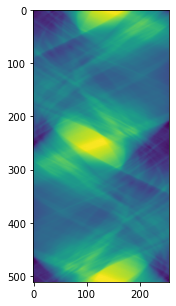

In [679]:
# download and read data

ntheta_roi = 512
nshift_roi = 256

r_supp = 1.0
r_roi = 0.5

filename_roi = 'roi-lambda-tomography.bin'
proj_data_roi = np.reshape(np.fromfile(filename_roi, dtype=np.float), (ntheta_roi, nshift_roi))

fig, axs = plt.subplots(1, 1, figsize=(12, 5), sharey=True)
axs.imshow(proj_data_roi)
plt.show()


Параметры: `theta` - равномерная сетка в `[0, 2pi]`, `shifts` - равномерная сетка в `[-r_roi, r_roi]`

Нарисуем $R^*R$. Видим, что область $ROI$ яркая, а остальная область мутная и мешает. Это связано с тем, что лучевые данные набраны так, что полная информация есть только для области $ROI$, что соответствует ее названию.

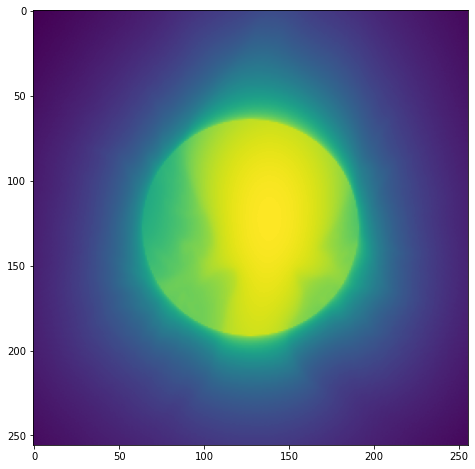

In [680]:
npixels = 256
delta = 2 * r_supp / npixels
image = adjradon2d(proj_data_roi, npixels, r_roi, r_supp)

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
im = axs.imshow(image)
plt.show()

Теперь будем строить $\Lambda f$. Строить будем полученное изображение только в ROI, так как только для нее собраны все нужные лучевые данные.

Решение через стандартный пакет питона для взятия лаплассиана.

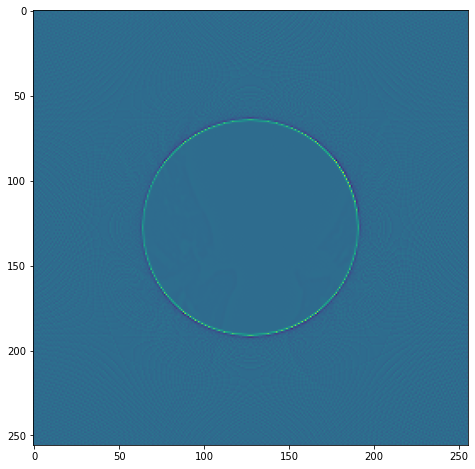

In [681]:
result = -ndimage.laplace(image)

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
im = axs.imshow(result)
plt.show()

Видим сигнулярное кольцо, которое мешает посмотреть картинку. Но видно, что контуры ожидаемого изображения отслеживаются. Видно, что за пределами $ROI$ муть, поэтому вообще отрежем всю область за кольцом (включая кольцо) и будем смотреть только область $ROI$.

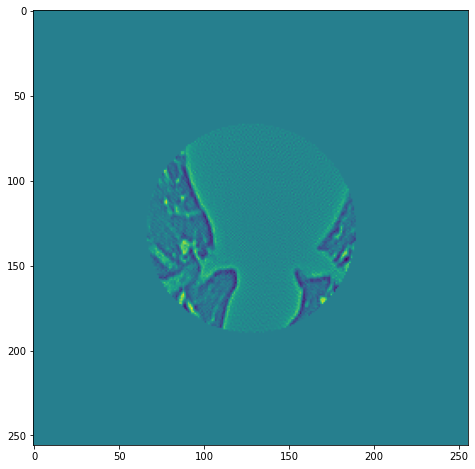

In [682]:
norm = np.min(result)/npixels/4

for i in range(npixels):
    for j in range(npixels):
        if (np.sqrt((-r_supp + i*delta)**2 + (-r_supp + j*delta)**2) >= r_roi - 5/npixels):
            result[i][j] = norm

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
im = axs.imshow(result)
plt.show()

Вычисление через разностные схемы. Использовала для лаплассиана 5-точечную схему 2 порядка.

$\frac{d^2f}{dx^2} + \frac{d^2f}{dy^2} = \frac{f_{i+1, j} - 2f_{i, j} + f_{i-1, j}}{h^2} + \frac{f_{i, j+1} - 2f_{i, j} + f_{i, j-1}}{h^2}$

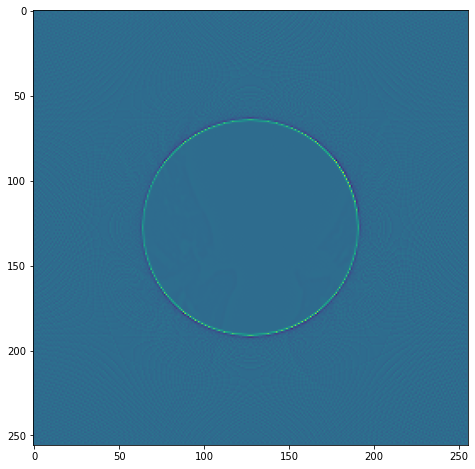

In [683]:
h = 2.0 * r_supp / npixels
result = np.zeros((npixels, npixels))

for i in range(1, npixels-1):
    for j in range(1, npixels-1):
        result[i][j] = -(image[i+1][j] - 2*image[i][j] + image[i-1][j] + image[i][j+1] - 2*image[i][j] + image[i][j-1])/h**2

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
im = axs.imshow(result)
plt.show()

Аналогично и здесь видим сингулярное кольцо, избавляемся от всех области за $ROI$.

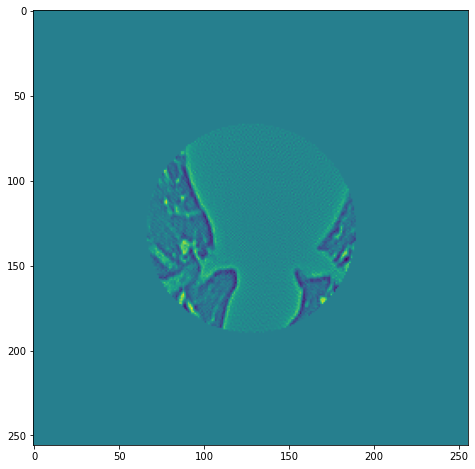

In [684]:
norm = np.min(result)/npixels/4

for i in range(npixels):
    for j in range(npixels):
        if (np.sqrt((-r_supp + i*delta)**2 + (-r_supp + j*delta)**2) >= r_roi - 5/npixels):
            result[i][j] = norm

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
im = axs.imshow(result)
plt.show()

Восстановление с помощью спектральных методов. Тут делается сначала $DFT$, потом умножение на $-(\frac{2\pi}{L} k)^2$ для $k < N/2$, и на $-(\frac{2\pi}{L}(k-\frac{N}{2})^2$ для $k > N/2)$. Соответственно из-за того, что картинка $2D$, то умножение идет на сумму этих квадратов. Затем делается $IDFT$. В итоге строим то, что получилось. 

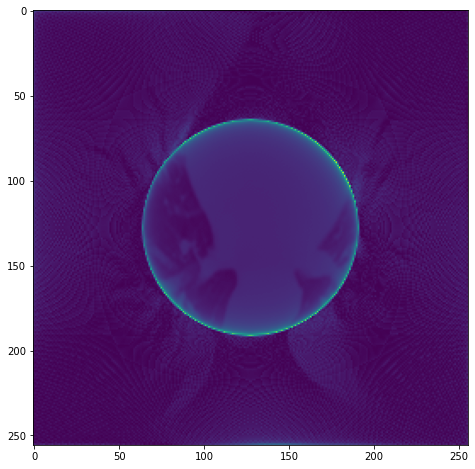

In [685]:
result = fftn(image)

for i in range(npixels):
    for j in range(npixels):
        result[i][j] = - (np.pi / npixels)**2 * (-i**2 + npixels*i - j**2 + npixels*j) * result[i][j]

result = ifftn(result)

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
im = axs.imshow(np.abs(result))
plt.show()

Кажется, что область за $ROI$ стала немного лучше, и область $ROI$ намного лучше различима, снова есть сингулярное кольцо. Избавимся от области за $ROI$. Почему-то совсем избавиться от кольца не удалось, сколько бы я не уменьшала радиус области.

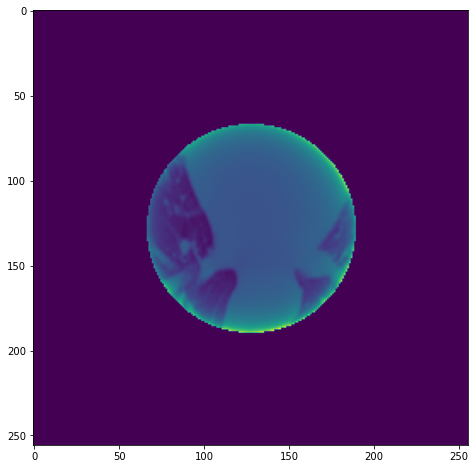

In [686]:
norm = np.min(result)/npixels/4

for i in range(npixels):
    for j in range(npixels):
        if (np.sqrt((-r_supp + i*delta)**2 + (-r_supp + j*delta)**2) >= r_roi - 5/npixels):
            result[i][j] = norm

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
im = axs.imshow(np.abs(result))
plt.show()

**Задание 1.4 (факультативно)** Докажите, что вообще говоря внутренняя задача томографии не имеет единственного решения. То есть преобразование Радона $R : C_0^{\infty}(\Omega) \rightarrow C^{\infty}((-r,r) \times S^1)$ неинъективно, где $\Omega$ - открытый еденичный шар в $R^2$ с центром в нуле, $r\in (0,1)$.

$Rf(s,\theta) = \int\limits_{-\infty}^{+\infty} f(s\theta+ t\theta^\perp)dt, \, s \in R, \, \theta\in S^1$

Уже проверяли линейность преобразования Радона.

$R(\alpha f + \beta g) = \alpha R(f) + \beta R(g)$

В итоге, если будет такая функция $g$, что $Rg = 0$, то получится $R(f + g) = R(f)$, но $f + g \neq f$.

Хотим найти такое $g$, что $Rg(s,\theta) = \int\limits_{-\infty}^{+\infty} g(s\theta+ t\theta^\perp)dt = 0$.

Можем представить себе систему колец, где значения на них задаются бесконечно градкой осциллирующей функцией, убывающей на бесконечности к нулю, при чем кольца посажены бесконечно часто. Тогда любая прямая пересечет бесконечное число колец, она будет проходить через положительные и отрицательные области так, что интеграл по ним будет равен 0, так как всегда найдутся области, убивающие друг друга.